<a href="https://colab.research.google.com/github/ravi7299/auto_image_annotate/blob/master/auto_image_annotate_FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:


# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

#for saving xml
import xml.etree.cElementTree as ET
from random import randrange
import os

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(10, 10))
  plt.grid(False)
  plt.imshow(image)

In [0]:
def load_and_resize_image(url, orig_size=True , new_width=256, new_height=256,
                              display=False):
  filename=None
  ###for downloading image from url
  #_, filename = tempfile.mkstemp(suffix=".jpg")
  #response = urlopen(url)
  #image_data = response.read()
  #image_data = BytesIO(image_data)
  
  
  pil_image = Image.open(url)
  if orig_size==True:
    new_width, new_height=pil_image.size
    
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  #image_np=np.array(pil_image_rgb)
  if filename is None:
     filename=((url.split('/'))[-1])
  pil_image_rgb.save(filename)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return (filename , pil_image_rgb)

In [0]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=2,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin




In [0]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [0]:
os.environ["TFHUB_CACHE_DIR"] = '../tmp/tfhub'

faster_rcnn = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
#mobilenet_v2="https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
#mobile_object_localizer ="https://tfhub.dev/google/object_detection/mobile_object_localizer_v1/1"

detector = hub.load(faster_rcnn).signatures['default']
#mobilenet_v2_detector = hub.load(mobilenet_v2).signatures['default']
#mobile_object_localizer_detector = hub.load(mobile_object_localizer).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [0]:
def generate_xml(image ,file_name_ext , class_names , boxes , class_scores ):
    im_width , im_height= image.size
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "filename").text = file_name_ext
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(im_width)
    ET.SubElement(size, "height").text = str(im_height)
    ET.SubElement(size, "depth").text = "3"
    
    n=0
    
    for j,i in enumerate(boxes):
        if class_scores[j]>0.49:
            n+=1
            ymin, xmin, ymax, xmax = tuple(boxes[j])
            objectBox = ET.SubElement(annotation, "object")
            ET.SubElement(objectBox, "name").text = class_names[j].decode("ascii")
            ET.SubElement(objectBox, "score").text = str(class_scores[j]*100)
            ET.SubElement(objectBox, "pose").text = "Unspecified"
            ET.SubElement(objectBox, "truncated").text = "0"
            ET.SubElement(objectBox, "difficult").text = "0"
            bndBox = ET.SubElement(objectBox, "bndbox")
            ET.SubElement(bndBox, "xmin").text = str(xmin*im_width)
            ET.SubElement(bndBox, "ymin").text = str(ymin*im_height)
            ET.SubElement(bndBox, "xmax").text = str(xmax*im_width)
            ET.SubElement(bndBox, "ymax").text = str(ymax*im_height)
    
    file_name,ext = file_name_ext.split('.') 
    print(file_name)
    ref = ET.ElementTree(annotation)
    file=data+file_name+ ".xml"
    ref.write(file)
    return file, n

In [0]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  #return converted_img.shape
  
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  t=end_time-start_time

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", t)

  #image_with_boxes = draw_boxes(
  #    img.numpy(), result["detection_boxes"],
  #    result["detection_class_entities"], result["detection_scores"])

  #generate_xml(img ,path , result["detection_class_entities"] , result["detection_boxes"] , result["detection_scores"])
  
  return result , img.numpy()
  #display_image(image_with_boxes)

In [0]:
## download sample images
!wget --no-check-certificate \
     https://sampledatasets.s3.amazonaws.com/obj_detection_images.zip \
    -O /tmp/images.zip

import zipfile

local_zip = '/tmp/images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()


--2020-05-19 00:19:43--  https://sampledatasets.s3.amazonaws.com/obj_detection_images.zip
Resolving sampledatasets.s3.amazonaws.com (sampledatasets.s3.amazonaws.com)... 52.216.105.59
Connecting to sampledatasets.s3.amazonaws.com (sampledatasets.s3.amazonaws.com)|52.216.105.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 915908 (894K) [application/zip]
Saving to: ‘/tmp/images.zip’

/tmp/images.zip     100%[===================>] 894.44K  2.26MB/s    in 0.4s    

2020-05-19 00:19:44 (2.26 MB/s) - ‘/tmp/images.zip’ saved [915908/915908]



In [0]:
data="../tmp/images/"

ext=['.jpg', '.jpeg', '.png', '.bmp']
images=[i for i in os.listdir(data) if os.path.splitext(i)[1] in ext]

print(images)

['men_in_zoo.jpg', 'img.jpg', 'traffic.jpg', 'camels.jpg', 'zoo.jpg', 'ducs.jpg', 'cats.jpg', 'traffic_hd.jpg', 'balls.jpg', '49606.jpg', 'cat_dog.jpg', 'penguin.jpg']


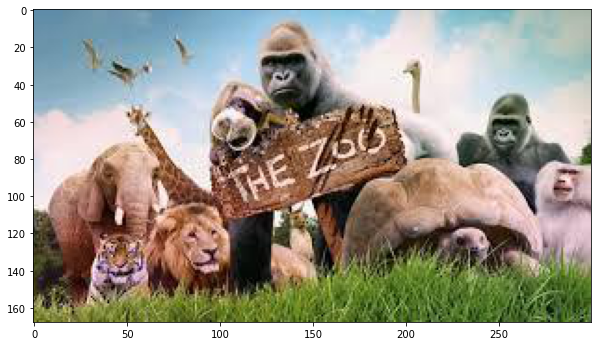

In [0]:
img_name=images[4] ##change index for different image listed above
image_url= data + img_name

image_path, img_pil = load_and_resize_image(image_url,orig_size=1, new_width=256, new_height=256,display=True)

In [0]:
result , img_np =run_detector(detector, image_path)

Found 100 objects.
Inference time:  31.32125735282898


In [0]:
result.keys()

dict_keys(['detection_class_labels', 'detection_class_entities', 'detection_class_names', 'detection_boxes', 'detection_scores'])

In [0]:
image_with_boxes=draw_boxes(img_np, result["detection_boxes"] , result["detection_class_entities"], result["detection_scores"], max_boxes=100, min_score=0.45)

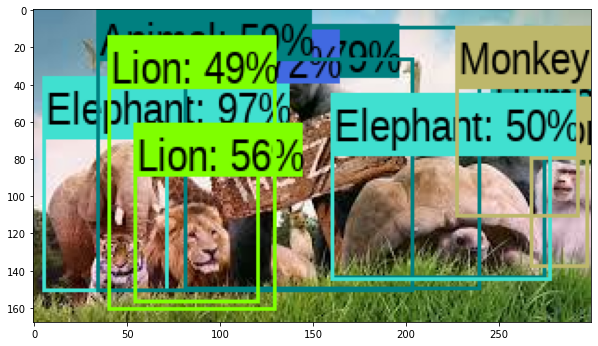

In [0]:

display_image(image_with_boxes)

In [0]:
f,t=generate_xml(img_pil ,img_name , result["detection_class_entities"] , result["detection_boxes"] , result["detection_scores"] )



zoo


In [0]:
from google.colab import files

files.download(image_url) #download image
files.download(f)   #download xml annotations